## Challenge Data

Déterminer le chiffre d’affaire chez un marchand de vin


Vous êtes  Développeur IA chez un marchand de vins de renom qui dispose d’un site internet pour ses ventes. Votre rôle est d’accompagner votre client dans sa transformation digitale. En effet pour le moment plusieurs painpoint sont présents. Par exemple, l’ERP utilisé n’est pas connecté au site internet : l’analyse des ventes sur internet est impossible, les outils sont rudimentaires, ect.. Votre mission se décline donc en plusieurs points :


 --> Faire un rapprochement entre l’export de la table de CMS qui contient les infos sur les produits vendus sur internet (nombre de ventes depuis la création du site internet, nom, ect..) et l’export de l’ERP ( références produits, stock, ect..)

  --> Après cette centralisation, le client souhaite avoir le chiffre d’affaire par produit et le total de chiffre d’affaire réalisé


 --> Le client se pose également des questions sur certains prix produits pour voir des éventuelles erreurs de saisies. Sa demande consiste à détecter d’éventuelles valeurs aberrantes et d’en faire une représentation graphique


NB : Un membre de l’équipe du client a créé un tableau Excel qui permet d’établir le lien entre la référence du produit dans l’ERP (product_id) et la référence du même produit dans la base de la boutique en ligne (SKU). La liste des product_id est exhaustive, mais pour les références côté Web, c’est moins sûr...Il a peiné à rapprocher certaines références.

L’analyse et l’identification des outliers se fera en utilisant les 4 méthodes suivantes:

L’approche statistique : Méthode du z score (supérieur à 2 standard deviation) et méthode des interquartiles

La méthode graphique : nuage de points ( les outliers seront d’une autre couleur que le reste des points) et le boxplot

Données: Liaison, web et ERP

## Rapprochement entre les fichiers 

In [101]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [102]:
#Lecture et stockage en dataframe du ficher erp
df_erp = pd.read_excel('erp.xlsx')
df_erp

C:\Users\utilisateur\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,product_id,onsale_web,price,stock_quantity,stock_status
0,3847,1,24.2,0,outofstock
1,3849,1,34.3,0,outofstock
2,3850,1,20.8,0,outofstock
3,4032,1,14.1,0,outofstock
4,4039,1,46.0,0,outofstock
...,...,...,...,...,...
820,7203,0,45.0,30,instock
821,7204,0,45.0,9,instock
822,7247,1,54.8,23,instock
823,7329,0,26.5,14,instock


In [103]:
#Lecture et stockage en dataframe du ficher liaison
df_liaison = pd.read_excel('liaison.xlsx')
df_liaison

C:\Users\utilisateur\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,product_id,id_web
0,3847,15298
1,3849,15296
2,3850,15300
3,4032,19814
4,4039,19815
...,...,...
820,7203,NaN
821,7204,NaN
822,7247,13127-1
823,7329,14680-1


In [104]:
#Lecture et stockage en dataframe du ficher web
df_web = pd.read_excel('web.xlsx')
df_web

C:\Users\utilisateur\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,bon-cadeau-25-euros,0,0,0,0.0,10.0,taxable,NaN,1.0,2018-06-01 13:53:46,...,bon-cadeau-de-25-euros,2018-06-01 14:13:57,2018-06-01 12:13:57,NaN,0.0,https://www.wine-spirit.fr/?post_type=product&...,0.0,product,NaN,0.0
1,15298,0,0,0,0.0,6.0,taxable,NaN,2.0,2018-02-08 12:58:52,...,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,NaN,0.0,https://www.wine-spirit.fr/?post_type=product&...,0.0,product,NaN,0.0
2,15296,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 13:49:41,...,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,NaN,0.0,https://www.wine-spirit.fr/?post_type=product&...,0.0,product,NaN,0.0
3,15300,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 14:08:36,...,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,NaN,0.0,https://www.wine-spirit.fr/?post_type=product&...,0.0,product,NaN,0.0
4,19814,0,0,0,0.0,3.0,taxable,NaN,2.0,2018-02-09 14:01:05,...,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,NaN,0.0,https://www.wine-spirit.fr/?post_type=product&...,0.0,product,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1508,16135,0,0,0,0.0,5.0,NaN,NaN,2.0,2020-04-25 13:22:38,...,mouthes-le-bihan-aime-chai-2015,2020-08-26 17:35:03,2020-08-26 15:35:03,NaN,0.0,https://www.wine-spirit.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
1509,15891,0,0,0,0.0,0.0,NaN,NaN,2.0,2020-05-02 14:53:40,...,camin-larredya-jurancon-sec-la-virada-2018,2020-08-26 17:35:02,2020-08-26 15:35:02,NaN,0.0,https://www.wine-spirit.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
1510,15887,0,0,0,0.0,0.0,NaN,NaN,2.0,2020-05-02 15:00:54,...,jamet-cote-rotie-fructus-voluptas-2018,2020-08-14 18:15:03,2020-08-14 16:15:03,NaN,0.0,https://www.wine-spirit.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
1511,13127-1,0,0,0,0.0,0.0,NaN,NaN,2.0,2020-06-09 15:42:04,...,clos-du-mont-olivet-chateauneuf-du-pape-2007-2,2020-07-20 17:09:06,2020-07-20 15:09:06,NaN,0.0,https://www.wine-spirit.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0


In [105]:
#Visualisation des doublons
web_duplicate = df_web.groupby('sku')['sku'].count()
print(web_duplicate.shape)

(714,)


In [106]:
#Elimination des doublons
df_web.drop_duplicates(subset=['sku'], keep = 'first', inplace=True)
df_web.shape

(715, 28)

In [107]:
#Liaison entre liaison et erp avec la colonne product_id
liaison_erp = pd.merge(df_erp,df_liaison,on='product_id')
print(liaison_erp)

     product_id  onsale_web  price  stock_quantity stock_status   id_web
0          3847           1   24.2               0   outofstock    15298
1          3849           1   34.3               0   outofstock    15296
2          3850           1   20.8               0   outofstock    15300
3          4032           1   14.1               0   outofstock    19814
4          4039           1   46.0               0   outofstock    19815
..          ...         ...    ...             ...          ...      ...
820        7203           0   45.0              30      instock      NaN
821        7204           0   45.0               9      instock      NaN
822        7247           1   54.8              23      instock  13127-1
823        7329           0   26.5              14      instock  14680-1
824        7338           1   16.3              45      instock    16230

[825 rows x 6 columns]


In [108]:
#Changement de nom de la colonne sku du fichier web pour pouvoir faire la liaison
df_web.rename(columns={'sku':'id_web'},inplace=True)

In [109]:
#liaison entre liaison et web avec la colonne id_web
erp_web = pd.merge(liaison_erp,df_web,on='id_web')
erp_web.columns

Index(['product_id', 'onsale_web', 'price', 'stock_quantity', 'stock_status',
       'id_web', 'virtual', 'downloadable', 'rating_count', 'average_rating',
       'total_sales', 'tax_status', 'tax_class', 'post_author', 'post_date',
       'post_date_gmt', 'post_content', 'post_title', 'post_excerpt',
       'post_status', 'comment_status', 'ping_status', 'post_password',
       'post_name', 'post_modified', 'post_modified_gmt',
       'post_content_filtered', 'post_parent', 'guid', 'menu_order',
       'post_type', 'post_mime_type', 'comment_count'],
      dtype='object')

## Chiffre d’affaire par produit et le total de chiffre d’affaire réalisé

In [110]:
#Création d'une colonne sales_by_product en multipliant le nombre de vente par le prix 
#pour obtenir le chiffre d'affaire par produit
erp_web['sales_by_product'] = erp_web['total_sales']*erp_web['price']

In [111]:
print('Le chiffre d\'affaire réaliser :',erp_web['sales_by_product'].sum())

Le chiffre d'affaire réaliser : 70568.6


## L’analyse et l’identification des outliers 

### L’approche statistique

Méthode du z score (supérieur à 2 standard deviation) 

In [112]:
#Selection des valeurs non nulles
erp_web_clean = erp_web[~erp_web['price'].isnull()]

In [113]:
#Calcul du zscore pour chaque produit et stockage dans une nouvelle colonne 
erp_web_clean['zscores'] = stats.zscore(np.array(erp_web_clean['price']))
erp_web_clean.head(30)

,product_id,onsale_web,price,stock_quantity,stock_status,id_web,virtual,downloadable,rating_count,average_rating,...,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count,sales_by_product,zscores
0,3847,1,24.2,0,outofstock,15298,0,0,0,0.0,...,2019-12-30 08:30:29,NaN,0.0,https://www.wine-spirit.fr/?post_type=product&...,0.0,product,NaN,0.0,145.2,-0.313321
1,3849,1,34.3,0,outofstock,15296,0,0,0,0.0,...,2019-12-21 08:00:17,NaN,0.0,https://www.wine-spirit.fr/?post_type=product&...,0.0,product,NaN,0.0,0.0,0.060491
2,3850,1,20.8,0,outofstock,15300,0,0,0,0.0,...,2020-06-26 16:15:03,NaN,0.0,https://www.wine-spirit.fr/?post_type=product&...,0.0,product,NaN,0.0,0.0,-0.439159
3,4032,1,14.1,0,outofstock,19814,0,0,0,0.0,...,2020-01-04 15:36:01,NaN,0.0,https://www.wine-spirit.fr/?post_type=product&...,0.0,product,NaN,0.0,42.3,-0.687134
4,4039,1,46.0,0,outofstock,19815,0,0,0,0.0,...,2020-01-04 15:36:10,NaN,0.0,https://www.wine-spirit.fr/?post_type=product&...,0.0,product,NaN,0.0,0.0,0.493522
5,4040,1,34.3,0,outofstock,15303,0,0,0,0.0,...,2019-11-02 12:25:07,NaN,0.0,https://www.wine-spirit.fr/?post_type=product&...,0.0,product,NaN,0.0,0.0,0.060491
6,4041,1,32.7,15,instock,14975,0,0,0,0.0,...,2020-08-14 16:15:02,NaN,0.0,https://www.wine-spirit.fr/?post_type=product&...,0.0,product,NaN,0.0,0.0,0.001274
7,4042,1,31.2,34,instock,16042,0,0,0,0.0,...,2020-08-14 08:15:02,NaN,0.0,https://www.wine-spirit.fr/?post_type=product&...,0.0,product,NaN,0.0,218.4,-0.054243
8,4043,1,60.0,12,instock,14980,0,0,0,0.0,...,2020-08-24 12:00:03,NaN,0.0,https://www.wine-spirit.fr/?post_type=product&...,0.0,product,NaN,0.0,180.0,1.011678
9,4045,1,42.6,66,instock,16041,0,0,0,0.0,...,2020-08-03 07:55:03,NaN,0.0,https://www.wine-spirit.fr/?post_type=product&...,0.0,product,NaN,0.0,596.4,0.367684


In [114]:
#Détermination des outliers pour les produits avec un zscore > 2
outliers =  erp_web_clean['zscores'] > 2
len(erp_web_clean['zscores'][outliers])

33

### Méthode des interquartiles

In [115]:
#Calcul de l'écart interquartile
q75, q25 = np.percentile(erp_web_clean['price'], [75 ,25])
IQR = q75 - q25
print(IQR)

27.9


In [116]:
#Détarmination des outliers et séparation des valeurs outliers et non outliers
lower_range = q25 - 1.5 * IQR
upper_range = q75 + 1.5 * IQR
outlier_list_IQR = [x for x in erp_web_clean['price'] if ((x < lower_range) or (x > upper_range))]
filtered_data = erp_web_clean.loc[~erp_web_clean['price'].isin(outlier_list_IQR)]
outlier_data = erp_web_clean.loc[erp_web_clean['price'].isin(outlier_list_IQR)]

## La méthode graphique 

### Nuage de points 

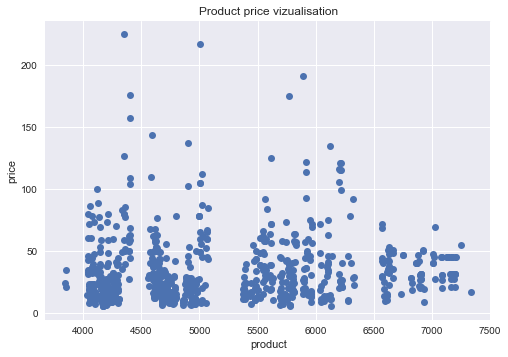

In [117]:
#Création du graphique en nuage de point
graph = erp_web_clean.plot(x='product_id', y='price', style='o', legend=False)

graph.set_xlabel("product")
graph.set_ylabel("price")

graph.set_title("Product price vizualisation")
plt.show()

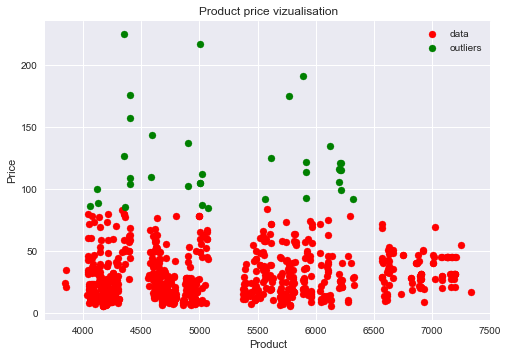

In [118]:
#création d'un graphique nuage de point avec une couleur différente pour les outliers (outilers déterminés à partir de l'écart interquartile)
x1= filtered_data['product_id']
x2= outlier_data['product_id']
y1=filtered_data['price']
y2=outlier_data['price']

plt.scatter(x1,y1,c="red",label='data')
plt.scatter(x2,y2,c="green", label='outliers')
plt.xlabel("Product")
plt.ylabel("Price")
plt.title("Product price vizualisation")
plt.legend()
plt.show()

### Boxplot


C:\Users\utilisateur\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


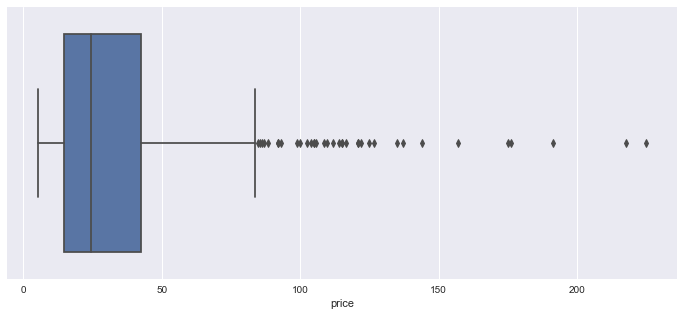

In [119]:
#Création d'un boxplot
plt.figure(figsize=(12,5))
sns.boxplot(erp_web_clean['price'])
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x274f2d0cb50>,
 'caps': [<matplotlib.lines.Line2D at 0x274f2d14130>,
 'boxes': [<matplotlib.lines.Line2D at 0x274f2d0c850>],
 'medians': [<matplotlib.lines.Line2D at 0x274f2d146d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x274f2d149a0>],
 'means': []}

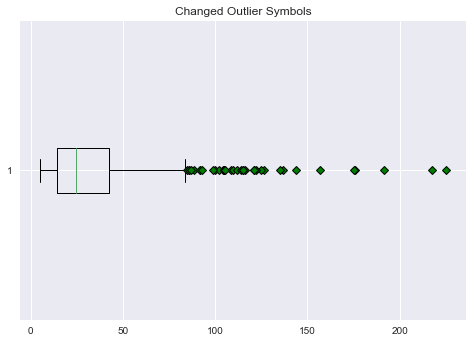

In [120]:
#création d'un boxplot avec modification des symboles pour les outliers
green_diamond = dict(markerfacecolor='g', marker='D')
fig1, ax3 = plt.subplots()
ax3.set_title('Changed Outlier Symbols')
ax3.boxplot(erp_web_clean['price'],vert=False, flierprops=green_diamond)